In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
#Utility Commands
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

# def to_gif(images, duration):
#   """Converts image sequence (4D numpy array) to gif."""
#   imageio.mimsave('./animation.gif', images, duration=duration)
#   return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [2]:
class PersonDetector:
    def __init__(self):
        model_path = "https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/singlepose-thunder/versions/4"
        self.movenet = self.load_model(model_path)
    
    def load_model(self,model_path):
        model = hub.load(model_path)
        movenet = model.signatures['serving_default']
        return movenet

    def get_model(self):
        return self.movenet
    
    def detect(self,input_image,inference_count=3):
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = self.movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

In [3]:
class ImageProcessor:
    def process_image(self,image_path):
        image = tf.io.read_file(image_path)
        image = tf.compat.v1.image.decode_jpeg(image)
        image = tf.expand_dims(image, axis=0)
        image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
        return image
    
    def display_image(self,image):
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(image[0])
        plt.show()
        
    def display_image_with_keypoints(self,image,keypoints):
        display_image = tf.cast(tf.image.resize_with_pad(
            image, 1280, 1280), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(
            np.squeeze(display_image.numpy(), axis=0), keypoints)
        plt.figure(figsize=(5, 5))
        plt.imshow(output_overlay)
        _ = plt.axis('off')

In [4]:
detector = PersonDetector()

In [5]:
imageProcessor = ImageProcessor()

In [8]:
def load_image(detector:PersonDetector,imageProcessor:ImageProcessor,path:str):
    keypoint_data = []
    image_label = []
    angle_data = []
    for images in os.listdir(path):
        image = imageProcessor.process_image(os.path.join(path,images))
        keypoints = detector.detect(image)
        
        key = keypoints[0][0]
        
        keypoint_data.append(np.ndarray.flatten(keypoints[0][0]))
        image_label.append(path.split('/')[-2])
        
        angle = calculate_angle(key)
        angle_data.append(angle)

    angle_data = np.array(angle_data)
    
    result = pd.DataFrame()
    result["data"] = keypoint_data
    result["label"] = image_label
    result["right knee"] = angle_data.T[0]
    result["left knee"] = angle_data.T[1]
    result["right hip"] = angle_data.T[2]
    result["left hip"] = angle_data.T[3]
    result["right elbow"] = angle_data.T[4]
    result["left elbow"] = angle_data.T[5]
    
    return result

def calculate_angle(key):
    
    right_wrist = key[10]
    left_wrist = key[9]
    
    right_elbow = key[8]
    left_elbow = key[7]
    
    right_shoulder = key[6]
    left_shoulder = key[5]
    
    right_hip = key[12]
    left_hip = key[11]
    
    right_knee = key[14]
    left_knee = key[13]
    
    right_ankle = key[16]
    left_ankle = key[15]
    
    angle_right_we = np.degrees(np.arctan2(right_wrist[1] - right_elbow[1], right_wrist[0] - right_elbow[0]))
    angle_right_es = np.degrees(np.arctan2(right_elbow[1] - right_shoulder[1], right_elbow[0] - right_shoulder[0]))
    angle_right_sh = np.degrees(np.arctan2(right_shoulder[1] - right_hip[1], right_shoulder[0] - right_hip[0]))
    angle_right_hk = np.degrees(np.arctan2(right_hip[1] - right_knee[1], right_hip[0] - right_knee[0]))
    angle_right_ka = np.degrees(np.arctan2(right_knee[1] - right_ankle[1], right_knee[0] - right_ankle[0]))
    
    angle_left_we = np.degrees(np.arctan2(left_wrist[1] - left_elbow[1], left_wrist[0] - left_elbow[0]))
    angle_left_es = np.degrees(np.arctan2(left_elbow[1] - left_shoulder[1], left_elbow[0] - left_shoulder[0]))
    angle_left_sh = np.degrees(np.arctan2(left_shoulder[1] - left_hip[1], left_shoulder[0] - left_hip[0]))
    angle_left_hk = np.degrees(np.arctan2(left_hip[1] - left_knee[1], left_hip[0] - left_knee[0]))
    angle_left_ka = np.degrees(np.arctan2(left_knee[1] - left_ankle[1], left_knee[0] - left_ankle[0]))
    
    angles = [angle_right_we,angle_right_es,angle_right_sh,angle_right_hk,angle_right_ka,angle_left_we,angle_left_es,angle_left_sh,angle_left_hk,angle_left_ka]
    angles = [angle if angle > 0 else angle + 180 for angle in angles]
    
    right_knee_angle = abs(angles[3] - angles[4])
    left_knee_angle = abs(angles[8] - angles[9])
    
    right_hip_angle = abs(angles[2] - angles[3])
    left_hip_angle = abs(angles[7] - angles[8])
    
    right_elbow_angle = abs(angles[0] - angles[1])
    left_elbow_angle = abs(angles[5] - angles[6])
    
    angles = [right_knee_angle,left_knee_angle,right_hip_angle,left_hip_angle,right_elbow_angle,left_elbow_angle]
    
    return angles



In [16]:
path = "../../Datasets/Trainer/processed/"
for folders in os.listdir(path):
    print(f'Processing {folders}')
    result = load_image(detector,imageProcessor,os.path.join(path,folders))
    print(f'Saving {folders}')
    result.to_csv(f"../../Datasets/Trainer/csv/{folders}.csv",index=False)

Processing pushup
Saving pushup
Processing situp
Saving situp
Processing squat
Saving squat
Processing standingFront
Saving standingFront
Processing standingSide
Saving standingSide


In [101]:
path = "../../Datasets/Trainer/csv_raw/"

df1 = pd.read_csv(os.path.join(path,"pushup.csv"))
df2 = pd.read_csv(os.path.join(path,"situp.csv"))
df3 = pd.read_csv(os.path.join(path,"squat.csv"))
df4 = pd.read_csv(os.path.join(path,"standingFront.csv"))
df5 = pd.read_csv(os.path.join(path,"standingSide.csv"))

dfs = [df1,df2,df3,df4,df5]
for df in dfs:
    df["angle"] = df[df.columns[2:]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)



df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)



x_train,x_test,y_train,y_test,yAngle_train,yAngle_test = train_test_split(df["data"],df["label"],df["angle"],test_size=0.2,random_state=42)
x_train,x_val,y_train,y_val,yAngle_train,yAngle_val = train_test_split(x_train,y_train,yAngle_train,test_size=0.1,random_state=42)

train_df = pd.DataFrame()
train_df["data"] = x_train
train_df["label"] = y_train
train_df["angle"] = yAngle_train

val_df = pd.DataFrame()
val_df["data"] = x_val
val_df["label"] = y_val
val_df["angle"] = yAngle_val

test_df = pd.DataFrame()
test_df["data"] = x_test
test_df["label"] = y_test
test_df["angle"] = yAngle_test

train_df.to_csv("../../Datasets/Trainer/csv_processed/train.csv",index=False)
val_df.to_csv("../../Datasets/Trainer/csv_processed/val.csv",index=False)
test_df.to_csv("../../Datasets/Trainer/csv_processed/test.csv",index=False)

    

In [102]:
train_df

,data,label,angle
5253,[0.28061217 0.53466886 0.5707864 0.26465243 0...,situp,"94.94265365600586,94.76234817504884,114.650081..."
717,[0.3657635 0.24923955 0.54567796 0.3520516 0...,pushup,"12.392730712890623,10.10626220703125,4.4919967..."
4008,[0.50792116 0.7084065 0.62425554 0.5026107 0...,situp,"111.23760223388672,108.94094848632812,76.97820..."
2479,[0.2906944 0.1830423 0.8032792 0.27036238 0...,pushup,"7.973281860351562,8.118682861328125,17.1819763..."
5601,[0.3099822 0.41131708 0.5496848 0.29331765 0...,situp,"96.87570190429688,96.88082122802734,33.2161979..."
...,...,...,...
4044,[0.39310536 0.39399818 0.4987116 0.37454075 0...,situp,"109.66102600097656,113.5357666015625,33.529468..."
3675,[0.55826414 0.75834334 0.30647957 0.5518789 0...,situp,"60.49694061279297,71.74858093261719,49.5243225..."
3769,[0.5672023 0.34723738 0.42272753 0.5672327 0...,situp,"115.13079452514648,110.42207717895508,49.65220..."
5423,[0.3761958 0.45785332 0.54050326 0.3616412 0...,situp,"66.36786651611328,71.7598648071289,111.4508895..."


In [105]:

def pose_landmarks(train_path,val_path,test_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    X_train = []
    X_val = []
    X_test = []
    temp_x_train = train_df.pop("data")
    temp_x_val = val_df.pop("data")
    temp_x_test = test_df.pop("data")
    
    for data in temp_x_train:
        spliited = data.replace("[","").replace("]","").replace("\n","").replace("  "," ").split(" ")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        X_train.append(data)
        
    for data in temp_x_val:
        spliited = data.replace("[","").replace("]","").replace("\n","").replace("  "," ").split(" ")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        X_val.append(data)
    
    for data in temp_x_test:
        spliited = data.replace("[","").replace("]","").replace("\n","").replace("  "," ").split(" ")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        X_test.append(data)
        
    classes = train_df["label"].unique()
    train_df["label_no"] = train_df["label"].map({classes[0]:0,classes[1]:1,classes[2]:2,classes[3]:3,classes[4]:4})
    val_df["label_no"] = val_df["label"].map({classes[0]:0,classes[1]:1,classes[2]:2,classes[3]:3,classes[4]:4})
    test_df["label_no"] = test_df["label"].map({classes[0]:0,classes[1]:1,classes[2]:2,classes[3]:3,classes[4]:4})
    
    y_train = tf.keras.utils.to_categorical(train_df.pop("label_no"))
    y_val = tf.keras.utils.to_categorical(val_df.pop("label_no"))
    y_test = tf.keras.utils.to_categorical(test_df.pop("label_no"))
    
    temp_yAngle_train = train_df.pop("angle")
    temp_yAngle_val = val_df.pop("angle")
    temp_yAngle_test = test_df.pop("angle")
    yAngle_train = []
    yAngle_val = []
    yAngle_test = []
    
    for data in temp_yAngle_train:
        spliited = data.split(",")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        yAngle_train.append(data)
    
    for data in temp_yAngle_val:
        spliited = data.split(",")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        yAngle_val.append(data)
        
    for data in temp_yAngle_test:
        spliited = data.split(",")
        data = np.array([float(i) for i in spliited if i != ""])
        data = data.astype(np.float64)
        yAngle_test.append(data)
        
    
    
    
    X_train = tf.stack(X_train)
    X_val = tf.stack(X_val)
    X_test = tf.stack(X_test)
    y_train = tf.stack(y_train)
    y_val = tf.stack(y_val)
    y_test = tf.stack(y_test)
    yAngle_train = tf.stack(yAngle_train)
    yAngle_val = tf.stack(yAngle_val)
    yAngle_test = tf.stack(yAngle_test)
    
    

    
    return X_train,X_val,X_test,y_train,y_val,y_test,classes,yAngle_train,yAngle_val,yAngle_test

X_train,X_val,X_test,y_train,y_val,y_test,classes,yAngle_train,yAngle_val,yAngle_test = pose_landmarks("../../Datasets/Trainer/csv_processed/train.csv","../../Datasets/Trainer/csv_processed/val.csv","../../Datasets/Trainer/csv_processed/test.csv")

In [110]:
def landmark_to_embedding(landmark):
    
    embedding = tf.keras.layers.Reshape((17, 3))(landmark)
    return embedding

inputs = tf.keras.Input(shape=(51),name="data_input")
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(layer)
layer = tf.keras.layers.Dense(256, activation=tf.nn.relu6)(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer2 = tf.keras.layers.Dense(256, activation=tf.nn.relu6)(layer)
outputs_1 = tf.keras.layers.Dense(5, activation="softmax",name="pose")(layer)
#
# outputs_3 = tf.keras.layers.Dense(6,name="angle")(layer2)

model = tf.keras.Model(inputs, outputs_1)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_input (InputLayer)     [(None, 51)]              0         
                                                                 
 dense_22 (Dense)            (None, 128)               6656      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 256)               33024     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                1644

In [111]:
class customcallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("loss") < 0.025 and logs.get("val_loss") < 0.025:
            self.model.stop_training = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32,
                    callbacks=[customcallback()],
                    epochs=1000)

Epoch 1/1000


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


161/161 [==============================] - 3s 6ms/step - loss: 1.2236 - accuracy: 0.4363 - val_loss: 1.1332 - val_accuracy: 0.6200
Epoch 2/1000
161/161 [==============================] - 1s 4ms/step - loss: 1.0617 - accuracy: 0.5380 - val_loss: 0.9873 - val_accuracy: 0.7215
Epoch 3/1000
161/161 [==============================] - 1s 4ms/step - loss: 0.9041 - accuracy: 0.6673 - val_loss: 0.7395 - val_accuracy: 0.7636
Epoch 4/1000
161/161 [==============================] - 1s 4ms/step - loss: 0.7212 - accuracy: 0.7533 - val_loss: 0.5492 - val_accuracy: 0.7881
Epoch 5/1000
161/161 [==============================] - 1s 8ms/step - loss: 0.5542 - accuracy: 0.8085 - val_loss: 0.4279 - val_accuracy: 0.8406
Epoch 6/1000
161/161 [==============================] - 1s 5ms/step - loss: 0.4584 - accuracy: 0.8404 - val_loss: 0.3436 - val_accuracy: 0.8862
Epoch 7/1000
161/161 [==============================] - 1s 5ms/step - loss: 0.3855 - accuracy: 0.8716 - val_loss: 0.3018 - val_accuracy: 0.9002
Epoch

In [1]:
model.evaluate(X_test,y_test)

NameError: name 'model' is not defined

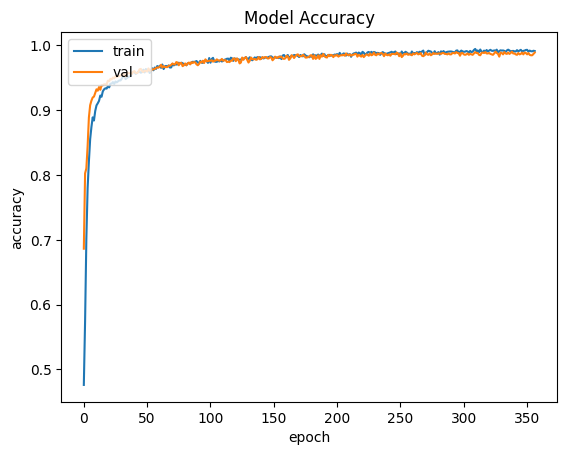

In [82]:
#plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.title('Model Accuracy')


plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('../Trainer/model/pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmptun08b1s\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmptun08b1s\assets


Model size: 76KB
